<a href="https://colab.research.google.com/github/gauravreddy08/learning-pytorch/blob/main/03_pytorch_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03 | Computer Vision with **PyTorch**
https://www.learnpytorch.io/03_pytorch_computer_vision/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


## **Fashion MNIST** dataset

In [3]:
train_data = datasets.FashionMNIST(
    root = 'data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root = 'data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



### Exploring the **data**

In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
image, label = train_data[0]
label, image.shape

(9, torch.Size([1, 28, 28]))

In [6]:
class_names = train_data.classes
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [7]:
class_to_idx = train_data.class_to_idx
print(class_to_idx)

{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


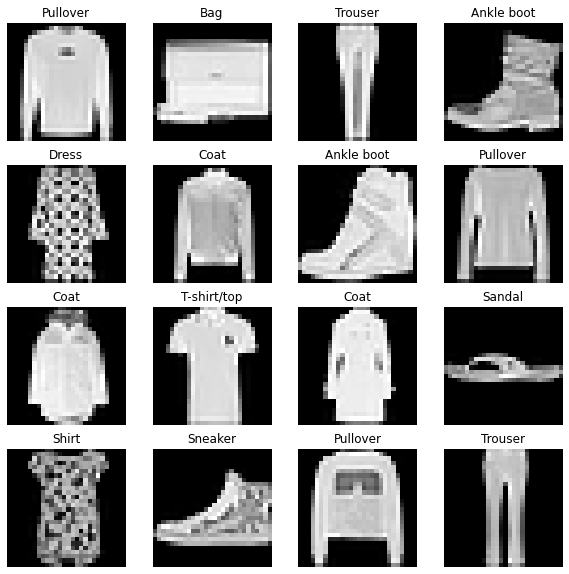

In [8]:
# torch.manual_seed(42)

fig = plt.figure(figsize=(10, 10))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  rand_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, l = train_data[rand_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap='gray');
  plt.title(class_names[l])
  plt.axis('off')

### Initialising **dataloaders**

In [9]:
from torch.utils.data import DataLoader 

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=False)

In [10]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## **Baseline** Model

In [11]:
class BaselineModel(nn.Module):
  def __init__(self, input_shape: int, 
               output_shape: int,
               hidden_units: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )
  
  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [12]:
torch.manual_seed(42)

model_0 = BaselineModel(input_shape = 28*28,
                        hidden_units = 16,
                        output_shape = len(class_names))

dummy_x = torch.rand([1, 28, 28])
model_0(dummy_x).shape

torch.Size([1, 10])

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [14]:
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py
from helper_functions import accuracy_fn

--2023-02-04 09:13:41--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10160 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.92K  --.-KB/s    in 0s      

2023-02-04 09:13:41 (73.8 MB/s) - ‘helper_functions.py’ saved [10160/10160]



In [15]:
from tqdm.auto import tqdm

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_loss = 0

    model_0.train()    
    for batch, (X, y) in enumerate(train_dataloader):
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)
    
    ### Testing
    test_loss, test_acc = 0, 0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.58258 | Test loss: 0.51229, Test acc: 81.93%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47560 | Test loss: 0.46959, Test acc: 83.44%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45187 | Test loss: 0.48482, Test acc: 82.94%



In [16]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
      for X, y in data_loader:
          X, y = X.to(device), y.to(device)
          test_pred = model(X)
          loss += loss_fn(test_pred, y)
          acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
      
      loss /= len(test_dataloader)
      acc /= len(test_dataloader)
  output = {'model_name': model.__class__.__name__,
            'model_loss': loss.item(),
            'model_acc': acc}
  print(output)
  return output

In [18]:
model_0_results = eval_model(model_0, test_dataloader, loss_fn, accuracy_fn, device='cpu')

{'model_name': 'BaselineModel', 'model_loss': 0.4848179817199707, 'model_acc': 82.93730031948881}


## **Non linear** Model

In [19]:
class NonLinearModel(nn.Module):
  def __init__(self, 
               input_shape: int,
               output_shape: int,
               hidden_units: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
    )
  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

torch.manual_seed(42)

model_1 = NonLinearModel(input_shape=28*28,
                         output_shape=len(class_names),
                         hidden_units=10).to(device)
                         
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

### ***Functionalising*** train/test loops

In [20]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  train_loss = 0
  train_acc = 0
  
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    preds = model(X)
    loss = loss_fn(preds, y)
    
    train_loss+=loss
    train_acc += accuracy_fn(y, torch.argmax(torch.softmax(preds, dim=1), dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return train_loss/len(dataloader), train_acc/len(dataloader)

In [21]:
def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              accuracy_fn,
              device: torch.device = device):
  test_loss = 0
  test_acc = 0
  
  model.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      preds = model(X)
      test_loss += loss_fn(preds, y)
      test_acc += accuracy_fn(y, torch.argmax(torch.softmax(preds, dim=1), dim=1))
    return test_loss/len(dataloader), test_acc/len(dataloader)

In [22]:
torch.manual_seed(42)

epochs = 5

for epoch in range(epochs):
  print(f'EPOCH: {epoch}')
  loss, acc = train_step(model_1, 
                         train_dataloader,
                         loss_fn, optimizer,
                         accuracy_fn, device)
  
  tloss, tacc = test_step(model_1, 
                          test_dataloader,
                          loss_fn,
                          accuracy_fn, device)
  print(f"Train Loss: {loss:.4f}, Train Acc: {acc:.2f}% | Test Loss: {tloss:.4f}, Test Acc: {tacc:.2f}% \n------------")

EPOCH: 0
Train Loss: 1.0920, Train Acc: 61.34% | Test Loss: 0.9564, Test Acc: 65.00% 
------------
EPOCH: 1
Train Loss: 0.7810, Train Acc: 71.93% | Test Loss: 0.7223, Test Acc: 73.91% 
------------
EPOCH: 2
Train Loss: 0.6703, Train Acc: 75.94% | Test Loss: 0.6850, Test Acc: 75.02% 
------------
EPOCH: 3
Train Loss: 0.6438, Train Acc: 76.52% | Test Loss: 0.6508, Test Acc: 76.13% 
------------
EPOCH: 4
Train Loss: 0.6289, Train Acc: 77.00% | Test Loss: 0.6528, Test Acc: 75.95% 
------------


In [23]:
model_1_results = eval_model(model_1, test_dataloader, loss_fn, accuracy_fn)

{'model_name': 'NonLinearModel', 'model_loss': 0.6527653932571411, 'model_acc': 75.94848242811501}


## **CNN** Model

In [39]:
class CNNModel(nn.Module):
  def __init__(self, input_shape, output_shape, hidden_units):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*7*7,
                  out_features = output_shape)

    )
  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [40]:
torch.manual_seed(42)

model_2 = CNNModel(input_shape=1,
                   output_shape=len(class_names),
                   hidden_units=10).to(device)
model_2

CNNModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [41]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [42]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 5

for epoch in range(epochs):
  print(f'EPOCH: {epoch}')
  loss, acc = train_step(model_2, 
                         train_dataloader,
                         loss_fn, optimizer,
                         accuracy_fn, device)
  
  tloss, tacc = test_step(model_2, 
                          test_dataloader,
                          loss_fn,
                          accuracy_fn, device)
  print(f"Train Loss: {loss:.4f}, Train Acc: {acc:.2f}% | Test Loss: {tloss:.4f}, Test Acc: {tacc:.2f}% \n------------")

EPOCH: 0
Train Loss: 0.5980, Train Acc: 78.26% | Test Loss: 0.3965, Test Acc: 85.61% 
------------
EPOCH: 1
Train Loss: 0.3627, Train Acc: 86.94% | Test Loss: 0.3452, Test Acc: 87.05% 
------------
EPOCH: 2
Train Loss: 0.3256, Train Acc: 88.25% | Test Loss: 0.3319, Test Acc: 87.98% 
------------
EPOCH: 3
Train Loss: 0.3025, Train Acc: 89.10% | Test Loss: 0.3218, Test Acc: 88.44% 
------------
EPOCH: 4
Train Loss: 0.2887, Train Acc: 89.49% | Test Loss: 0.2984, Test Acc: 89.36% 
------------


In [44]:
model_2_results = eval_model(model_2, test_dataloader, loss_fn, accuracy_fn)

{'model_name': 'CNNModel', 'model_loss': 0.2983921468257904, 'model_acc': 89.3570287539936}


## Comparing our **models**

In [46]:
results = pd.DataFrame([model_0_results,
                        model_1_results,
                        model_2_results,])
results

,model_name,model_loss,model_acc
0,BaselineModel,0.484818,82.937300
1,NonLinearModel,0.652765,75.948482
2,CNNModel,0.298392,89.357029


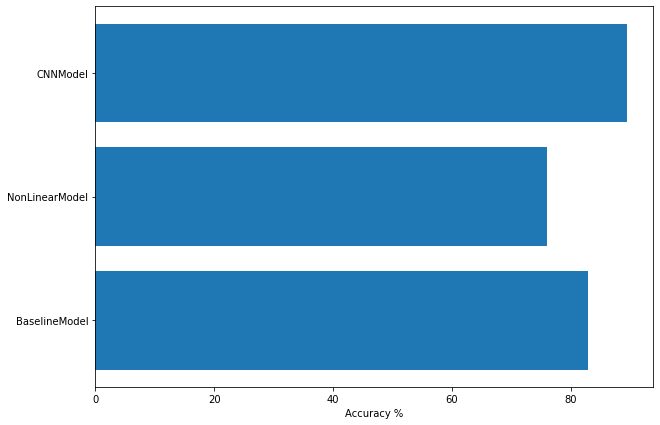

In [53]:
fig = plt.figure(figsize=(10, 7))
plt.barh(results['model_name'], results['model_acc'])
plt.xlabel("Accuracy %");

In [62]:
y_preds = []

model_2.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_preds.append(torch.argmax(torch.softmax(model_2(X), dim=1), dim=1))

y_preds = torch.cat(y_preds)
len(y_preds)

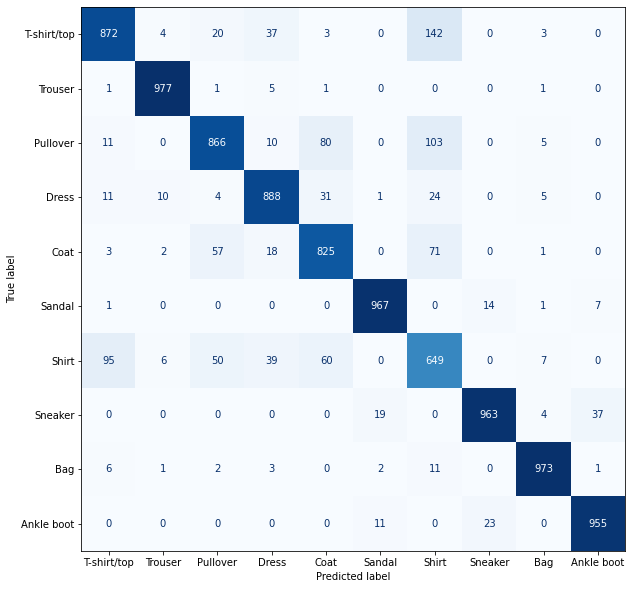

In [102]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import time
cm = confusion_matrix(y_preds.cpu(), test_data.targets)

fig, ax = plt.subplots(figsize=(10, 10))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names)


cm_display.plot(cmap='Blues', colorbar=False, ax=ax, include_values=True)
plt.show()